In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os

%matplotlib inline

In [5]:
path = '../datasets/food-101/train/'

In [6]:
fried_rice = os.listdir(path + 'fried_rice/')
ramen = os.listdir(path + 'ramen/')

In [8]:
resnet = tf.keras.applications.resnet50.ResNet50(include_top=False)
preprocess_input = tf.keras.applications.resnet50.preprocess_input
image = tf.keras.preprocessing.image

In [9]:
def extract_features(img_paths, batch_size=64):
    """ This function extracts image features for each image in img_paths using ResNet50 bottleneck layer.
        Returned features is a numpy array with shape (len(img_paths), 2048).
    """
    global resnet
    n = len(img_paths)
    img_array = np.zeros((n, 224, 224, 3))
    
    for i, path in enumerate(img_paths):
        img = image.load_img(path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        x = preprocess_input(img)
        img_array[i] = x
    
    X = resnet.predict(img_array, batch_size=batch_size, verbose=1)
    X = X.reshape((n, 2048))
    return X

In [11]:
X = extract_features(
    list(map(lambda x: path + 'fried_rice/' + x, fried_rice)) + list(map(lambda x: path + 'ramen/' + x, ramen))
)
y = np.array([1] * len(fried_rice) + [0] * len(ramen))

1600/1600 [==============================] - 320s 200ms/step


In [34]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [35]:
def net():
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation=tf.nn.relu),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])
    return model

In [41]:
np.random.seed(42)

batch_size = 64
epochs = 5

model = net()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=batch_size,
                    epochs=epochs)

Train on 1120 samples, validate on 480 samples
Epoch 1/5
1120/1120 [==============================] - 1s 825us/step - loss: 0.3837 - acc: 0.8366 - val_loss: 0.1460 - val_acc: 0.9458
Epoch 2/5
1120/1120 [==============================] - 0s 138us/step - loss: 0.0960 - acc: 0.9688 - val_loss: 0.1089 - val_acc: 0.9563
Epoch 3/5
1120/1120 [==============================] - 0s 131us/step - loss: 0.0635 - acc: 0.9795 - val_loss: 0.1074 - val_acc: 0.9604
Epoch 4/5
1120/1120 [==============================] - 0s 131us/step - loss: 0.0558 - acc: 0.9839 - val_loss: 0.0988 - val_acc: 0.9604
Epoch 5/5
1120/1120 [==============================] - 0s 135us/step - loss: 0.0309 - acc: 0.9946 - val_loss: 0.0921 - val_acc: 0.9625


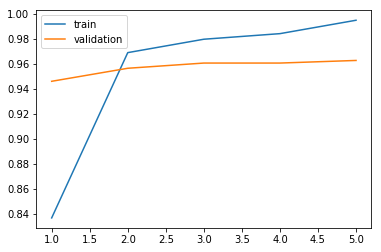

In [42]:
plt.plot(range(1,epochs+1), history.history['acc'], label='train')
plt.plot(range(1,epochs+1), history.history['val_acc'], label='validation')
plt.legend();

In [43]:
test_path = '../datasets/food-101/test/'
test = os.listdir(test_path)

In [45]:
X_test = extract_features(
    list(map(lambda x: test_path + x, test))
)

400/400 [==============================] - 73s 183ms/step


In [46]:
y_pred = model.predict(X_test)

In [55]:
pred = pd.DataFrame({
    'id': test,
    'kelas': (y_pred > .5).reshape(-1)
})
pred['kelas'] = pred['kelas'].map({True: 1, False: 0})

In [57]:
pred.to_csv('pred.csv', index=False)